In [5]:
import os
import fitz  # PyMuPDF for PDFs
import pandas as pd
import pptx # from python-pptx
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END # from langgraph
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
import requests
import ast
import re
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import spacy
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

# Initialize our LLM
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key = api_key)

/Users/chaoyangye/Documents/Computation/langgraph_agent/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/chaoyangye/Documents/Computation/langgraph_agent/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1: Define State

We need to track
- Whether it's a file containing pubmed abstracts (LLM)

- Find the right abstract containing the keywords (LLM)

- If so extract PMID, make URL and retrieve pubmed webpage in pubmed format and extract drug substance info

- Compile author, journal, PMID and drug substance into a table as output

- identify biomedical entities from the abstract, and then predict if the chemical used is the right drug for the target using BERT transormer model from huggingface

In [29]:
class PubmedState(TypedDict):
    file_path: Optional[str]
    text_snippet: Optional[str]           
    is_pubmed: Optional[bool]
    keyword: Optional[str] # filter for only relevant abstract
    filtered_abstract: Optional[str]
    filtered_pmid: List[str]
    error_msg: Optional[str]
    drug_substance: List[str]
    pred_outcome: List[str]

# Step 2: Define Nodes

In [31]:
def extract_text(state: PubmedState) -> PubmedState:
    file_path = state["file_path"]
    ext = os.path.splitext(file_path)[-1].lower()
    text_snippet = ""

    if ext in [".txt", ".csv"]:
        with open(file_path, "r", encoding="utf-8") as f:
            text_snippet = f.read()
    elif ext in [".xlsx", ".xls"]:
        df = pd.read_excel(file_path)
        text_snippet = "\n".join(df.astype(str).values.flatten())
    elif ext == ".pdf":
        with fitz.open(file_path) as doc:
            text_snippet = "\n".join(page.get_text() for page in doc)
    elif ext in [".pptx", ".ppt"]:
        prs = pptx.Presentation(file_path)
        text_snippet = "\n".join([slide.shapes.text for slide in prs.slides if hasattr(slide.shapes, 'text')])
    else:
        raise ValueError("Unsupported file format")
    print(text_snippet[:50])
    return {
        "text_snippet": text_snippet
        }

In [32]:
def check_pubmed(state: PubmedState) -> PubmedState:
    try:
        text_snippet = state["text_snippet"]
        prompt = f"""
        Determine if the following content is from a valid PubMed file.
        Respond with 'Yes' if it is, 'No' if it is not.
        Content:
        {text_snippet[:1000]}  # Limit to avoid exceeding token limits
        """
        response = model.invoke(prompt)
        is_pubmed = "Yes" in response.content
    except Exception as e:
        print(f"Error processing file: {e}")
        is_pubmed = False
    return {"is_pubmed": is_pubmed}

In [33]:
def filter_pubmed(state: PubmedState) -> PubmedState:
    try:
        text_snippet = state["text_snippet"]
        keyword = state["keyword"]
        filtered_pmid = state["filtered_pmid"]
        prompt = f"""
        Filter for the abstract containing {keyword} in only the author affilication portion of following content.
        Return with a table of 4 columns listing authors, journal, publication time and PMID.
        Content:
        {text_snippet}  # Limit to avoid exceeding token limits
        """
        response = model.invoke(prompt)
        filtered_abstract = response.content
        prompt = f"""
        Filter for a list of PMID from the following content.
        Return with a list of PMID
        Content:
        {filtered_abstract}
        """
        response = model.invoke(prompt)
        filtered_pmid = response.content
    except Exception as e:
        print(f"Error processing file: {e}")
        filtered_abstract = ""
        filtered_pmid = ""
    return {
        "filtered_abstract": filtered_abstract,
        "filtered_pmid": filtered_pmid
        }

In [34]:
# Define routing logic
def direct_abstract(state: PubmedState) -> str:
    if state["is_pubmed"]:
        return "pubmed"
    else:
        return "not pubmed"

In [35]:
def print_error(state: PubmedState) -> PubmedState:
    return {
        "error_msg": "This file does not contain pubmed abstracts"
    }

In [36]:
# append drug substance info to the table
def add_drug_substance(state: PubmedState) -> PubmedState:
    pmids = state["filtered_pmid"].strip('`\n[]')
    pmids = ast.literal_eval(pmids)
    drug_substance_list = []
    print("search start", pmids)
    for pmid in pmids:
        url = "https://pubmed.ncbi.nlm.nih.gov/" + str(pmid) + "/?format=pubmed"
        # search txt in url linked webpage
        # extract drug substance under the RN tags
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an error for bad responses

            webpage_content = response.text
        
            rn_strings = re.findall(r'^RN.*\((.*?)\)', webpage_content, re.MULTILINE)
            # Concatenate the extracted drug substance info into a list
            drug_substance_list.append(rn_strings)

        except requests.RequestException as e:
            print(f"Error retrieving URL: {e}")
            drug_substance_list.append()

    return {"drug_substance": drug_substance_list}

In [52]:
def chem_bio_pred(state: PubmedState) -> str:
    
    # Load biomedical entity recognition
    nlp = spacy.load("en_core_sci_sm")

    # Load BioBERT model fine-tuned on biomedical relations
    model_name = "distilbert-base-uncased"  # swap with BioBERT if you fine-tune later
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # skipping fine tuning

    # Extract biomedical entities from abstract
    # skipped for now
    # doc = nlp(patient_report)
    # entities = [(ent.text, ent.label_) for ent in doc.ents]
    # print("\n🧬 Extracted Entities:")
    # for ent, label in entities:
    #     print(f" - {ent} ({label})")

    # Create input for transformer (e.g., check relation between drug and protein)
    chem_entity = state["drug_substance"] # this is a list, each element is also a list containing multiple drug substances
    bio_entity = state["keyword"]
    pred_outcome = []

    for ent in chem_entity:
        for ent_i in ent:
            classifier = pipeline("text-classification", model=model_name, tokenizer=tokenizer)
            input_text = f"{ent_i} interacts with {bio_entity}"
            prediction = classifier(input_text)
            pred_outcome.append(ent_i + " with a prediction score " + str(round(prediction[0]["score"], 2)))

    return {
        "pred_outcome": pred_outcome
    }

# Step 3: Build graph

In [53]:
def build_graph():
    graph = StateGraph(PubmedState)
    graph.add_node("extract_text", extract_text)
    graph.add_node("check_pubmed", check_pubmed)
    graph.add_node("filter_pubmed", filter_pubmed)
    graph.add_node("print_error", print_error)
    graph.add_node("add_drug_substance", add_drug_substance)
    graph.add_node("chem_bio_pred", chem_bio_pred)

    graph.set_entry_point("extract_text")
    graph.add_edge("extract_text", "check_pubmed")

    # add coniditional edge
    graph.add_conditional_edges(
        "check_pubmed",
        direct_abstract,
        {
            "pubmed": "filter_pubmed",
            "not pubmed": "print_error"
        }
    )
    
    graph.add_edge("print_error", END)
    graph.add_edge("filter_pubmed", "add_drug_substance")
    graph.add_edge("add_drug_substance", "chem_bio_pred")
    graph.add_edge("chem_bio_pred", END)
    return graph

# Step 4: Visualize graph

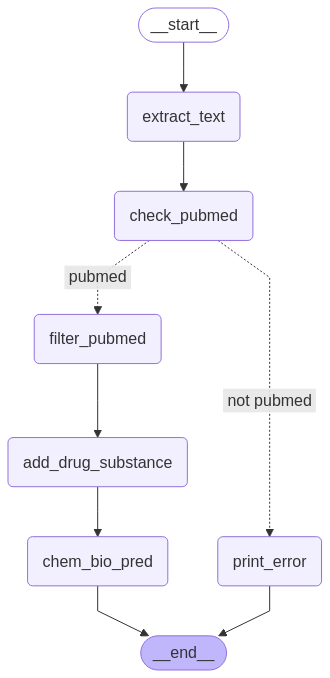

In [54]:
# Example usage:
graph = build_graph()
compiled_graph = graph.compile()

# visualize graph
from IPython.display import Image, display
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

# Step 5: Execute

In [67]:
# processing and identifying file
# then extract abstracts containing keywords
print("\nProcessing file...")

pubmed_result = compiled_graph.invoke({
    "file_path": "data/abstract-Schizophre-set.txt",
    "text_snippet": "",          
    "is_pubmed": None,
    "filtered_abstract": None,
    "filtered_pmid": None,
    "keyword": "Karuna",
    "error_msg": None,
    "drug_substance": None,
    "pred_outcome": None
})

print("Pubmed file or not?\n", pubmed_result["is_pubmed"])
print("Any error during the process?\n", pubmed_result["error_msg"])
print("Filtered abstract containing keyword:\n", pubmed_result["filtered_abstract"])
print("Filtered PMID\n", pubmed_result["filtered_pmid"])
print("Found cited drug substance\n", pubmed_result["drug_substance"])

for pred in pubmed_result["pred_outcome"]:
    print(pubmed_result["keyword"] + " is predicted to interact with " + pred)


Processing file...
1. Behav Brain Res. 2021 May 7;405:113201. doi: 10
search start (35758639, 36273943, 38537670)


/Users/chaoyangye/Documents/Computation/langgraph_agent/.venv/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_sm' (0.5.1) was trained with spaCy v3.4.1 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are 

Pubmed file or not?
 True
Any error during the process?
 None
Filtered abstract containing keyword:
 ```
| Authors         | Journal            | Publication Time | PMID      |
|-----------------|--------------------|------------------|-----------|
| Paul SM, Yohn SE, Popiolek M, Miller AC, Felder CC | Am J Psychiatry | 2022 Sep        | 35758639  |
| Yohn SE, Weiden PJ, Felder CC, Stahl SM | Trends Pharmacol Sci | 2022 Dec        | 36273943  |
| Paul SM, Yohn SE, Brannan SK, Neugebauer NM, Breier A | Biol Psychiatry | 2024 Oct 15     | 38537670  |
```
Filtered PMID
 ```
[35758639, 36273943, 38537670]
```
Found cited drug substance
 [['Antipsychotic Agents', 'Muscarinic Agonists', 'Receptors, Muscarinic'], ['Muscarinic Agonists', 'Receptors, Muscarinic', 'Acetylcholine', 'Receptor, Muscarinic M1'], ['Antipsychotic Agents', 'Receptors, Muscarinic', 'Muscarinic Agonists', 'xanomeline', 'Pyridines', 'Thiadiazoles']]
Karuna is predicted to interact with Antipsychotic Agents with a predicti

In [65]:
for pred in pubmed_result["pred_outcome"]:
    print(pubmed_result["keyword"] + " is predicted to interact with " + pred)

Karuna is predicted to interact with Antipsychotic Agents with a prediction score 0.52
Karuna is predicted to interact with Muscarinic Agonists with a prediction score 0.56
Karuna is predicted to interact with Receptors, Muscarinic with a prediction score 0.51
Karuna is predicted to interact with Muscarinic Agonists with a prediction score 0.52
Karuna is predicted to interact with Receptors, Muscarinic with a prediction score 0.52
Karuna is predicted to interact with Acetylcholine with a prediction score 0.51
Karuna is predicted to interact with Receptor, Muscarinic M1 with a prediction score 0.54
Karuna is predicted to interact with Antipsychotic Agents with a prediction score 0.51
Karuna is predicted to interact with Receptors, Muscarinic with a prediction score 0.57
Karuna is predicted to interact with Muscarinic Agonists with a prediction score 0.52
Karuna is predicted to interact with xanomeline with a prediction score 0.51
Karuna is predicted to interact with Pyridines with a pre

In [63]:
pubmed_result["pred_outcome"]

['Antipsychotic Agents with a prediction score 0.52',
 'Muscarinic Agonists with a prediction score 0.56',
 'Receptors, Muscarinic with a prediction score 0.51',
 'Muscarinic Agonists with a prediction score 0.52',
 'Receptors, Muscarinic with a prediction score 0.52',
 'Acetylcholine with a prediction score 0.51',
 'Receptor, Muscarinic M1 with a prediction score 0.54',
 'Antipsychotic Agents with a prediction score 0.51',
 'Receptors, Muscarinic with a prediction score 0.57',
 'Muscarinic Agonists with a prediction score 0.52',
 'xanomeline with a prediction score 0.51',
 'Pyridines with a prediction score 0.51',
 'Thiadiazoles with a prediction score 0.51']